<a href="https://colab.research.google.com/github/jadercaro/Curso-Deep-Learning-20242/blob/main/U5_LAB_01_Multivariate_time_series_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB 5.1 - Time series prediction

In [ ]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()

replicating local resources


In [ ]:
from local.lib.rlxmoocapi import submit, session
import inspect
session.LoginSequence(endpoint=init.endpoint, course_id=init.course_id, lab_id="L05.01", varname="student");

logging in as jader.caro@udea.edu.co ... please wait

-------------
using course session 2021.deeplearning::udea.20242
success!! you are logged in
-------------


In [ ]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
    %load_ext tensorboard
import tensorflow as tf
tf.__version__

setting tensorflow version in colab
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


'2.17.0'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Context

The aim of this LAB is to test the capacity of recurrent networks to predict future values of pollution based on past vallues of pollution and other environmental time series.

Load data:

In [ ]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('local/data/raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('local/data/pollution.csv',compression='gzip')

<ipython-input-5-27f39fc3a17b>:6: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  dataset = read_csv('local/data/raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
<ipython-input-5-27f39fc3a17b>:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  dataset = read_csv('local/data/raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
<ipython-input-5-27f39fc3a17b>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


Let's take a look at the time series:

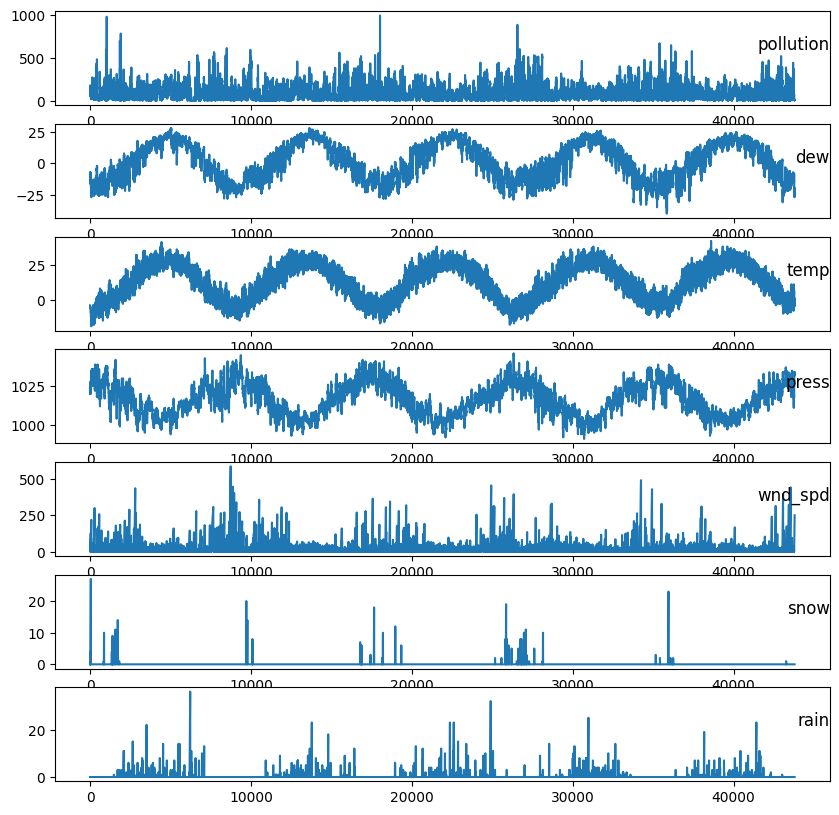

In [ ]:
from pandas import read_csv
# load dataset
dataset = read_csv('local/data/pollution.csv', compression='gzip', header=0, index_col=0)
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure(figsize=(10,10))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(dataset.values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [ ]:
dataset.columns[0]

'pollution'

In [ ]:
MVSeries = dataset.values

## TASK 1.

In order to train a DL model for time series prediction, the first step is to split the data correctly. Define a function valled create_datasetMV that takes the dataset of environmental time series (MVSeries), and return two arrays: the input array and the target array. This function will be used to set up the data for predicting the next value of the pollution time series. During the experiments, we are going to test different look backs (observations of the time series in past times), so the function should have an input parameter to define this number.

**Hint**:

The original data is organized in a matrix where rows are observations and columns are variables.

First of all, create a function to format the data as the model requires: [n_samples,n_times,n_features]

Takes as reference the following function where the input dataset is a univariate time series:

In [ ]:
def create_datasetMV(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

test your code with the following case, which should get the following results:

(5, 2, 4) (5,)

--

[[ 0  7 14 21]
 [ 1  8 15 22]] 2

--

[[ 1  8 15 22]
 [ 2  9 16 23]] 3

--

 (3, 4, 4) (3,)

--

[[ 0  7 14 21]
 [ 1  8 15 22]
 [ 2  9 16 23]
 [ 3 10 17 24]] 4

--

[[ 1  8 15 22]
 [ 2  9 16 23]
 [ 3 10 17 24]
 [ 4 11 18 25]] 5

In [ ]:
timeseries = np.arange(28).reshape(4,7)
X_temp, Y_temp = create_datasetMV(timeseries.T, look_back=2)
print(X_temp.shape,Y_temp.shape)
print('--------------------------')
print(X_temp[0,:,:], Y_temp[0])
print('--------------------------')
print(X_temp[1,:,:], Y_temp[1])
print('--------------------------')
X_temp, Y_temp = create_datasetMV(timeseries.T, look_back=4)
print(X_temp.shape,Y_temp.shape)
print('--------------------------')
print(X_temp[0,:,:], Y_temp[0])
print('--------------------------')
print(X_temp[1,:,:], Y_temp[1])

(5, 2, 4) (5,)
--------------------------
[[ 0  7 14 21]
 [ 1  8 15 22]] 2
--------------------------
[[ 1  8 15 22]
 [ 2  9 16 23]] 3
--------------------------
(3, 4, 4) (3,)
--------------------------
[[ 0  7 14 21]
 [ 1  8 15 22]
 [ 2  9 16 23]
 [ 3 10 17 24]] 4
--------------------------
[[ 1  8 15 22]
 [ 2  9 16 23]
 [ 3 10 17 24]
 [ 4 11 18 25]] 5


**Submit your solution:**

In [ ]:
student.submit_task(namespace=globals(), task_id='T1');

## Task 2.

Create a function that takes as input one type of recurrent layer from this set: 'SimpleRNN', 'LSTM', or 'GRU', and return an instances of a DL model. The model must use two recurrent layers (of selected type) with 10 neurons each, and one output layer with only one single output.

You must return an instance of a `Sequential` model. **DO NOT** invoke `compile` or `fit`.

In [ ]:
def Recurrent_Model(X_train,layer_type='SimpleRNN'):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import SimpleRNN
    from tensorflow.keras.layers import LSTM
    from tensorflow.keras.layers import GRU
    from tensorflow.keras.layers import Dense

    input_shape = (X_train.shape[1],X_train.shape[2])

    model = Sequential()

    if layer_type =="SimpleRNN":
      model.add(SimpleRNN(10,activation = 'relu',return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2])))
      model.add(SimpleRNN(10,activation = 'relu'))


    elif layer_type =="LSTM":
      model.add(LSTM(units=10,return_sequences=True,input_shape=input_shape))
      model.add(LSTM(10))
    elif layer_type =="GRU":
      model.add(GRU(units=10,return_sequences=True,input_shape=input_shape))
      model.add(GRU(10))

    model.add(Dense(1))

    return model

**Submit your solution:**

In [ ]:
student.submit_task(namespace=globals(), task_id='T2');

### Let's train the models:

**Warning**: Run this part only if you have already passed Tasks 1 and 2.

In [ ]:
from local.lib.DataPreparationRNN import DataPreparation, TrainModel, Plot_Task2
from sklearn.metrics import mean_squared_error

look_back = 1
X_train, y_train, X_test, y_test, scaler = DataPreparation(MVSeries,look_back, create_datasetMV)
model = Recurrent_Model(X_train)
model = TrainModel(X_train,y_train,model)
y_est = model.predict(X_test)
print('RMSE con los datos normalizados')
print(np.sqrt(mean_squared_error(y_test.flatten(), y_est.flatten())))
print('RMSE con los datos en la magnitud original')
print(np.sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(-1,1)), scaler.inverse_transform(y_est))))

452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
RMSE con los datos normalizados
0.023825428029893445
RMSE con los datos en la magnitud original
23.682475499483246


In [ ]:
mse = np.zeros((3,5))
for i in range(1,6):
    X_train, y_train, X_test, y_test, scaler = DataPreparation(MVSeries,i,create_datasetMV)
    for j,k in enumerate(['LSTM','GRU','SimpleRNN']):
        model = Recurrent_Model(X_train,layer=k)
        model = TrainModel(X_train,y_train,model)
        y_est = model.predict(X_test)
        mse[j,i-1] = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(-1,1)), scaler.inverse_transform(y_est)))
Plot_Task2(mse)

TypeError: Recurrent_Model() got an unexpected keyword argument 'layer'

<div class="alert alert-block alert-info"><b>Note:</b>
    
A good exercise is to repeat the training process using a <a href="https://rramosp.github.io/2021.deeplearning/content/U5.00%20-%20Intro%20time%20series.html#">time-series cross-validation strategy</a>, estimate confindence intervals, and include them into the plot.

</div>

### Let's see how the real and predicted time series look like:

In [ ]:
lookback = 3
X_train, y_train, X_test, y_test, scaler = DataPreparation(MVSeries,lookback, create_datasetMV)
model = Recurrent_Model(X_train,layer='LSTM')
model = TrainModel(X_train,y_train,model)
y_est = model.predict(X_test)

TypeError: Recurrent_Model() got an unexpected keyword argument 'layer'

In [ ]:
times = MVSeries.shape[0]
train_size = int(times * 0.67)

y_est_t = model.predict(X_train)
trainPredictPlot = np.empty_like(MVSeries[:,0])
trainPredictPlot[:] = np.nan
trainPredictPlot[lookback:train_size] = scaler.inverse_transform(y_est_t).flatten()
testPredictPlot = np.empty_like(MVSeries[:,0])
testPredictPlot[:] = np.nan
testPredictPlot[train_size:] = scaler.inverse_transform(y_est).flatten()

plt.figure()
plt.plot(MVSeries[-400:,0],label='Original series')
#plt.plot(trainPredictPlot,label='train prediction',alpha=0.7)
plt.plot(testPredictPlot[-400:],label='Predicted series',alpha=0.7)
plt.title(f'Prediction of pollution for look_back={lookback}')
plt.legend()
plt.show()

## Task 3

Create two functions:

- **create_datasetMV_MultipleTimes**: this function takes the MVSeries time series and return X and Y arrays to train a RNN.  Yet, in addition to dataset and lookback, the function should also receive one parameter to define the prediction horizon, i.e. the number of times ahead the model will predict (n_steps_ahead).


- **Recurrent_Model_MO**: this function takes as input one type of recurrent layer from this set: 'SimpleRNN', 'LSTM', or 'GRU', and the same former prediction horizon parameter and return an instances of a DL model. The model must use two recurrent layers (of selected type) with 15 neurons each, and one output layer with n_steps_ahead outputs, the purpose is to build a model that predicts all the times ahead at once.

In [ ]:
def create_datasetMV_TimesAhead(dataset,look_back=1, n_steps_ahead=1):
    import math
    dataX,dataY = [],[]
    count = look_back
    for i in range(0,dataset.shape[0]-(look_back),n_steps_ahead):
      b = []
      for j in range(look_back):
        a = dataset[i+j,:]
        b.append(a)
      if count + n_steps_ahead > dataset.shape[0]:
        break
      dataX.append(b)
      dataY.append(dataset[count:count+n_steps_ahead,0])
      count = count + n_steps_ahead

    return np.array(dataX),np.array(dataY)

test your code with the following case, which should get the following results:

(4, 2, 4) (4, 2)

--
[[ 0 10 20 30]
 [ 1 11 21 31]] [2 3]

--
[[ 2 12 22 32]
 [ 3 13 23 33]] [4 5]

--
(2, 4, 4) (2, 3)

--
[[ 0 10 20 30]
 [ 1 11 21 31]
 [ 2 12 22 32]
 [ 3 13 23 33]] [4 5 6]

--
[[ 3 13 23 33]
 [ 4 14 24 34]
 [ 5 15 25 35]
 [ 6 16 26 36]] [7 8 9]

In [ ]:
timeseries = np.arange(40).reshape(4,10)
X_temp, Y_temp = create_datasetMV_TimesAhead(timeseries.T, look_back=2, n_steps_ahead=2)
print(X_temp.shape,Y_temp.shape)
print('--------------------------')
print(X_temp[0,:,:], Y_temp[0])
print('--------------------------')
print(X_temp[1,:,:], Y_temp[1])
print('--------------------------')
X_temp, Y_temp = create_datasetMV_TimesAhead(timeseries.T, look_back=4, n_steps_ahead=3)
print(X_temp.shape,Y_temp.shape)
print('--------------------------')
print(X_temp[0,:,:], Y_temp[0])
print('--------------------------')
print(X_temp[1,:,:], Y_temp[1])

(4, 2, 4) (4, 2)
--------------------------
[[ 0 10 20 30]
 [ 1 11 21 31]] [2 3]
--------------------------
[[ 2 12 22 32]
 [ 3 13 23 33]] [4 5]
--------------------------
(2, 4, 4) (2, 3)
--------------------------
[[ 0 10 20 30]
 [ 1 11 21 31]
 [ 2 12 22 32]
 [ 3 13 23 33]] [4 5 6]
--------------------------
[[ 3 13 23 33]
 [ 4 14 24 34]
 [ 5 15 25 35]
 [ 6 16 26 36]] [7 8 9]


In [ ]:
def Recurrent_Model_MO(X_train,layer_type='SimpleRNN',n_steps_ahead=1):#Options for layer_type: 'SimpleRNN', 'LSTM', 'GRU'
    #X_train is used for setting input_shape dimensions
    model = ...
    return model

In [ ]:
def Recurrent_Model_MO(X_train,layer_type='SimpleRNN',n_steps_ahead=1):#Options for layer_type: 'SimpleRNN', 'LSTM', 'GRU'
    #X_train is used for setting input_shape dimensions
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import SimpleRNN
    from tensorflow.keras.layers import LSTM
    from tensorflow.keras.layers import GRU
    from tensorflow.keras.layers import Dense

    model = Sequential()

    if layer_type =="SimpleRNN":
      model.add(SimpleRNN(15,activation = 'relu',return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2])))
      model.add(SimpleRNN(15,activation = 'relu'))


    elif layer_type =="LSTM":
      model.add(LSTM(units=15,return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2])))
      model.add(LSTM(15))
    elif layer_type =="GRU":
      model.add(GRU(units=15,return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2])))
      model.add(GRU(15))

    model.add(Dense(n_steps_ahead))

    return model

**Submit your solution:**

In [ ]:
student.submit_task(namespace=globals(),  task_id='T3');

### Let's train the models:

**Warning**: Run this part only if you have already passed Task 3.

In [ ]:
from local.lib.DataPreparationRNN import DataPreparation_TimesAhead, TrainModel, Plot_Task2
from sklearn.metrics import mean_squared_error

look_back = 3
n_steps_ahead = 2
X_train, y_train, X_test, y_test, scaler = DataPreparation_TimesAhead(MVSeries,look_back, n_steps_ahead, create_datasetMV_TimesAhead)
model = Recurrent_Model_MO(X_train, n_steps_ahead=n_steps_ahead)
model = TrainModel(X_train,y_train,model)
y_est = model.predict(X_test)
print('RMSE con los datos normalizados')
print(np.sqrt(mean_squared_error(y_test.flatten(), y_est.flatten())))
print('RMSE con los datos en la magnitud original')
print(np.sqrt(mean_squared_error(scaler.inverse_transform(y_test.flatten().reshape(-1,1)), scaler.inverse_transform(y_est.flatten().reshape(-1,1)))))

#### Let's see how the models perform for a 2 times ahead prediction:

In [ ]:
mse = np.zeros((3,5))
n_steps = 2
for i in range(1,6):
    for j,k in enumerate(['LSTM','GRU','SimpleRNN']):
        X_train, y_train, X_test, y_test, scaler = DataPreparation_TimesAhead(MVSeries,i, n_steps, create_datasetMV_TimesAhead)
        model = Recurrent_Model_MO(X_train, k, n_steps_ahead=n_steps)
        model = TrainModel(X_train,y_train,model)
        y_est = model.predict(X_test)
        mse[j,i-1] = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test.flatten().reshape(-1,1)), scaler.inverse_transform(y_est.flatten().reshape(-1,1))))
Plot_Task2(mse)

Now for a 3 times ahead prediction...

In [ ]:
mse = np.zeros((3,5))
n_steps = 3
for i in range(1,6):
    for j,k in enumerate(['LSTM','GRU','SimpleRNN']):
        X_train, y_train, X_test, y_test, scaler = DataPreparation_TimesAhead(MVSeries,i, n_steps, create_datasetMV_TimesAhead)
        model = Recurrent_Model_MO(X_train, k, n_steps_ahead=n_steps)
        model = TrainModel(X_train,y_train,model)
        y_est = model.predict(X_test)
        mse[j,i-1] = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test.flatten().reshape(-1,1)), scaler.inverse_transform(y_est.flatten().reshape(-1,1))))
Plot_Task2(mse)

## Task 4

Create a function Recurrent_Model_ED to solve the same problem addressed in the former task, but using en encoder-decoder architecure. The encoder must be coposed of a stack of two recurrent layers of 15 neurons each and the decoder must be composed of one recurrent layer of 10 neurons. As in the previous task, the function must receive a layer_type parameter and a n_steps_ahead parameter to define the prediction horizon.

In [ ]:
def Recurrent_Model_ED(X_train,layer_type='SimpleRNN',n_steps_ahead=1):#Options for layer_type: 'SimpleRNN', 'LSTM', 'GRU'
    #X_train is used for setting input_shape dimensions

    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import SimpleRNN
    from tensorflow.keras.layers import LSTM
    from tensorflow.keras.layers import GRU
    from tensorflow.keras.layers import Dense
    from tensorflow.keras.layers import RepeatVector
    from tensorflow.keras.layers import TimeDistributed

    model = Sequential()

    if layer_type =="SimpleRNN":
      model.add(SimpleRNN(15,activation = 'relu',return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2])))
      model.add(SimpleRNN(15,activation = 'relu'))
      model.add(RepeatVector(n_steps_ahead))
      model.add(SimpleRNN(10,activation = 'relu',return_sequences=True))



    elif layer_type =="LSTM":
      model.add(LSTM(units=15,return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2])))
      model.add(LSTM(15))
      model.add(RepeatVector(n_steps_ahead))
      model.add(LSTM(10,return_sequences=True))
    elif layer_type =="GRU":
      model.add(GRU(units=15,return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2])))
      model.add(GRU(15))
      model.add(RepeatVector(n_steps_ahead))
      model.add(GRU(10,return_sequences=True))

    model.add(TimeDistributed(Dense(1)))
    model.summary()
    return model

**Submit your solution:**

In [ ]:
student.submit_task(namespace=globals(), task_id='T4');

### Let's train the models:

**Warning**: Run this part only if you have already passed Tasks 3 and 4.

In [ ]:
from local.lib.DataPreparationRNN import DataPreparation_TimesAhead, TrainModel, Plot_Task2
from sklearn.metrics import mean_squared_error

look_back = 3
n_steps_ahead = 2
X_train, y_train, X_test, y_test, scaler = DataPreparation_TimesAhead(MVSeries,look_back, n_steps_ahead, create_datasetMV_TimesAhead)
model = Recurrent_Model_ED(X_train, n_steps_ahead=n_steps_ahead)
model = TrainModel(X_train,y_train,model)
y_est = model.predict(X_test)
print('RMSE con los datos normalizados')
print(np.sqrt(mean_squared_error(y_test.flatten(), y_est.flatten())))
print('RMSE con los datos en la magnitud original')
print(np.sqrt(mean_squared_error(scaler.inverse_transform(y_test.flatten().reshape(-1,1)), scaler.inverse_transform(y_est.flatten().reshape(-1,1)))))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)             │ (None, 3, 15)               │             345 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ (None, 15)                  │             465 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 2, 15)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_4 (SimpleRNN)             │ (None, 2, 10)               │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 2, 1)                │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,081 (4.22 KB)

 Trainable params: 1,081 (4.22 KB)

 Non-trainable params: 0 (0.00 B)

KeyboardInterrupt: 

#### Let's see how the encoder models perform for a 2 times ahead prediction:

In [ ]:
mse = np.zeros((3,5))
n_steps = 2
for i in range(1,6):
    for j,k in enumerate(['LSTM','GRU','SimpleRNN']):
        X_train, y_train, X_test, y_test, scaler = DataPreparation_TimesAhead(MVSeries,i, n_steps, create_datasetMV_TimesAhead)
        model = Recurrent_Model_ED(X_train, k, n_steps_ahead=n_steps)
        model = TrainModel(X_train,y_train,model)
        y_est = model.predict(X_test)
        mse[j,i-1] = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test.flatten().reshape(-1,1)), scaler.inverse_transform(y_est.flatten().reshape(-1,1))))
Plot_Task2(mse)

Now for a 3 times ahead prediction...

In [ ]:
mse = np.zeros((3,5))
n_steps = 3
for i in range(1,6):
    for j,k in enumerate(['LSTM','GRU','SimpleRNN']):
        X_train, y_train, X_test, y_test, scaler = DataPreparation_TimesAhead(MVSeries,i, n_steps, create_datasetMV_TimesAhead)
        model = Recurrent_Model_ED(X_train, k, n_steps_ahead=n_steps)
        model = TrainModel(X_train,y_train,model)
        y_est = model.predict(X_test)
        mse[j,i-1] = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test.flatten().reshape(-1,1)), scaler.inverse_transform(y_est.flatten().reshape(-1,1))))
Plot_Task2(mse)

**UNGRADED TASK**

Create two plots of the real and predicted time series for the multi-output and encoder-decoder models, similar to that created at the end of task 2. Use onle the last 400 samples of the real and test series. **Note**: pay attention to the shape of the output array for each type of architecture. You should get the following results:

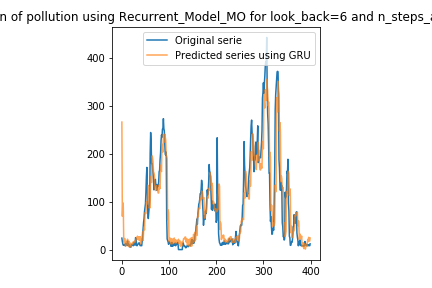

In [ ]:
from IPython.display import Image
Image("local/imgs/Recurrent_Model_MO.png")

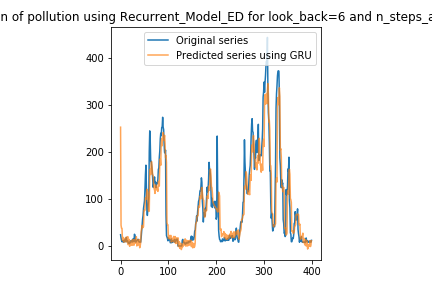

In [ ]:
Image("local/imgs/Recurrent_Model_ED.png")